In [1]:
import nltk
import re

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.metrics import mean_absolute_error
import os

In [16]:
def display_df(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', 10)

In [17]:
df_attr = pd.read_csv('train_dataset_Дипстрой//attr.csv')
df_attr['date_report'] = pd.to_datetime(df_attr['date_report'])
df_attr = df_attr.rename(
    columns={
        'состояние площадки': 'square_status',
        'Площадь': 'square',
        'Генпроектировщик': 'gen_proect',
        'Генподрядчик': 'gen_podr',
        'Кол-во рабочих': 'n_workers',
    }
)

df_ksg = pd.read_csv(
    'train_dataset_Дипстрой//dataset_hackaton_ksg__v2__23062023__1710_GMT3.csv',
    encoding = "utf-8",
    sep=';',
    dtype = {'Экспертиза':'object'}
)

df_ksg = df_ksg.drop(['Unnamed: 0', '№ п/п'], axis=1)
df_ksg = df_ksg.rename(
    columns={
        'Кодзадачи': 'task_key',
        'НазваниеЗадачи': 'task_name',
        'ПроцентЗавершенияЗадачи': 'completion_percentage',
        'ДатаНачалаЗадачи': 'date_start_task',
        'ДатаОкончанияЗадачи': 'date_end_task',
        'ДатаначалаБП0': 'date_start_bpo',
        'ДатаокончанияБП0': 'date_end_bpo',
        'Статуспоэкспертизе': 'examination_status',
        'Экспертиза': 'examination'
    }
)

df_ksg.head()

,obj_prg,obj_subprg,obj_key,task_key,task_name,completion_percentage,date_start_task,date_end_task,date_start_bpo,date_end_bpo,examination_status,examination,date_report
0,Образование,Общеобразовательные учреждения,022-0527,1,Предпроектные работы,0.0,2022-01-14,2023-03-30,NaN,NaN,NaN,NaN,2023.01.17
1,Образование,Общеобразовательные учреждения,022-0354,1,Предпроектные работы,0.0,2022-12-01,2023-07-27,NaN,NaN,NaN,NaN,2023.01.17
2,Образование,Дошкольные учреждения,022-0513,1,Предпроектные работы,0.0,2023-01-23,2023-09-29,NaN,NaN,NaN,NaN,2023.01.17
3,Образование,Дошкольные учреждения,020-0684,1,Предпроектные работы,0.0,2020-11-03,2022-02-01,2020-11-03,2021-12-29,NaN,NaN,2023.01.17
4,Образование,Дошкольные учреждения,019-0589,1,Предпроектные работы,0.0,2020-11-03,2022-05-16,2020-11-03,2021-12-29,NaN,NaN,2023.01.17


## Обработка пропусков

In [18]:
# заполняем пропуски дат в договоре
df_ksg = df_ksg.sort_values(['obj_key', 'task_key', 'date_end_bpo'])
df_ksg = df_ksg.fillna({'date_end_bpo': df_ksg.groupby(['obj_key','task_key'])['date_end_bpo'].transform('first')})
df_ksg = df_ksg.sort_values(['obj_key', 'task_key', 'date_end_bpo'])
df_ksg = df_ksg.fillna({'date_start_bpo': df_ksg.groupby(['obj_key','task_key'])['date_start_bpo'].transform('first')})

# заполнем пропуски в экспертизах
df_ksg['examination_status'] = df_ksg['examination_status'].fillna(0.0)
df_ksg['examination'] = df_ksg['examination'].fillna('0')

#дропаем пропуски, где не дано названия задачи и кода
df_ksg = df_ksg.dropna(subset='task_name')
df_ksg = df_ksg.dropna(subset='task_key')

df_ksg['date_start_task'] = pd.to_datetime(df_ksg['date_start_task'])
df_ksg['date_end_task'] = pd.to_datetime(df_ksg['date_end_task'])
df_ksg['date_start_bpo'] = pd.to_datetime(df_ksg['date_start_bpo'])
df_ksg['date_end_bpo'] = pd.to_datetime(df_ksg['date_end_bpo'])
df_ksg['date_report'] = pd.to_datetime(df_ksg['date_report'])
df_ksg.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1059799 entries, 8 to 366668
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   obj_prg                1059799 non-null  object        
 1   obj_subprg             1059799 non-null  object        
 2   obj_key                1059799 non-null  object        
 3   task_key               1059799 non-null  object        
 4   task_name              1059799 non-null  object        
 5   completion_percentage  1059799 non-null  float64       
 6   date_start_task        1059799 non-null  datetime64[ns]
 7   date_end_task          1059799 non-null  datetime64[ns]
 8   date_start_bpo         855422 non-null   datetime64[ns]
 9   date_end_bpo           856073 non-null   datetime64[ns]
 10  examination_status     1059799 non-null  float64       
 11  examination            1059799 non-null  object        
 12  date_report            1059799 non

## Исправление названий задач

In [19]:
nltk.download('stopwords')
stop_words = list(stopwords.words('russian'))
print(stop_words[:5])
df_ksg['task_name'] = df_ksg['task_name'].apply(lambda x : ' '.join(re.sub(r'[^а-яА-ЯёЁ]', ' ', x.lower()).split()))
df_ksg['task_name'] = df_ksg['task_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df_ksg['task_name'] = df_ksg['task_key']+'_'+df_ksg['task_name']




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ykolt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во', 'не', 'что']


## Сбор таргета

In [20]:
#сбор таргета
df_ksg['target'] = df_ksg.groupby(['obj_key', 'task_name'])['date_end_task'].transform(lambda x: x.shift(-1)-x)
df_ksg['target'] = df_ksg['target'].dt.days
df_ksg = df_ksg.dropna(subset='target')
df_ksg['target'] = df_ksg['target'].astype(int)

<Axes: >

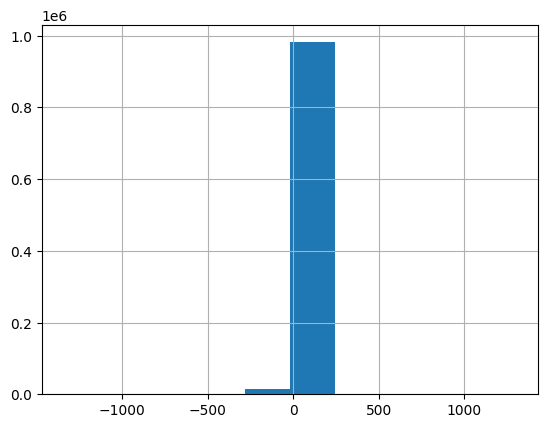

In [21]:
df_ksg['target'].hist()

## Обработка аномалий

In [22]:
df_ksg.shape

(998280, 14)

In [23]:
q001 = df_ksg['target'].quantile(0.01)
q099 = df_ksg['target'].quantile(0.99)

anomaly_df = (
    df_ksg
    .loc[(df_ksg['target'] > q099)|(df_ksg['target'] < q001)]
    .groupby(['obj_key', 'task_name'], as_index=False)
    .count()
)

anomaly_df = anomaly_df[['obj_key', 'task_name']]
df_ksg_new = df_ksg.copy()

df_ksg_new = pd.merge(df_ksg_new, anomaly_df, on=['obj_key', 'task_name'], how='outer', indicator=True)   

df_ksg_new = df_ksg_new.query("_merge == 'left_only'").drop(columns='_merge')
df_ksg_new.shape

(772916, 14)

(0.0, 50000.0)

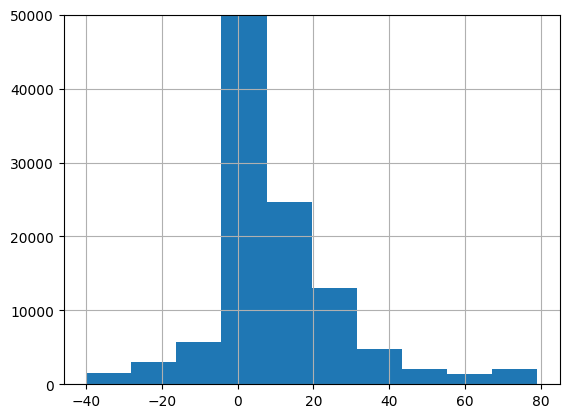

In [24]:
df_ksg_new['target'].hist()
plt.ylim(0,50000)

In [25]:
#df_ksg_new[(df_ksg_new['obj_key']=='017-0520') & (df_ksg_new['task_key']=='6')].sort_values(by='date_report')
df_ksg_new.head()

,obj_prg,obj_subprg,obj_key,task_key,task_name,completion_percentage,date_start_task,date_end_task,date_start_bpo,date_end_bpo,examination_status,examination,date_report,target
0,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,0.0,0,2023-01-17,0
1,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,0.0,0,2023-01-23,0
2,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,0.0,0,2023-02-06,0
3,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,0.0,0,2023-02-13,0
4,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,0.0,0,2023-02-20,0


## Инженерия фич

In [26]:
# месяц и сезон для каждой даты
dates = [col for col in df_ksg_new.columns if 'date' in col]
for date_name in dates:
    df_ksg_new.loc[:,f'{date_name}_month'] = df_ksg_new[date_name].dt.month
    df_ksg_new.loc[:,f'{date_name}_season'] =  (df_ksg_new[f'{date_name}_month'] % 12 + 3) // 3

# разница дат
date_pairs = {
    'date_end_task':'date_start_task',
    'date_end_bpo':'date_start_bpo',
    'date_start_task':'date_start_bpo',
    'date_end_task':'date_end_bpo',
}
for date_name1, date_name2 in date_pairs.items():
    df_ksg_new.loc[:,f'diff_{date_name1[5:]}_{date_name2[5:]}'] = (df_ksg_new[date_name1] - df_ksg_new[date_name2]).dt.days.astype(float)

df_ksg_new = df_ksg_new.merge(df_attr, how='left', on=['obj_key', 'date_report'])

In [27]:
df_ksg_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772916 entries, 0 to 772915
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   obj_prg                    772916 non-null  object        
 1   obj_subprg                 772916 non-null  object        
 2   obj_key                    772916 non-null  object        
 3   task_key                   772916 non-null  object        
 4   task_name                  772916 non-null  object        
 5   completion_percentage      772916 non-null  float64       
 6   date_start_task            772916 non-null  datetime64[ns]
 7   date_end_task              772916 non-null  datetime64[ns]
 8   date_start_bpo             630246 non-null  datetime64[ns]
 9   date_end_bpo               630807 non-null  datetime64[ns]
 10  examination_status         772916 non-null  float64       
 11  examination                772916 non-null  object  

### Подрядчик

In [28]:
def preproc(df, info):
    col = info.columns[0]
    print(col)
    if col =='target':
        info = info.drop(columns=['target'])
        print(len(df['date_report'].unique()))
        for date_rep in df['date_report'].unique():
            info_val = df.loc[(df['date_report'] < date_rep), 'target'].describe()
            info_list = [
                date_rep,
                info_val['count'],
                info_val['mean'],
                info_val['std']
            ]
            info.loc[len(info)] = info_list
        return info
    else:
        for val in df[col].dropna().unique():
            for date_rep in df['date_report'].unique():
                info_val = df.loc[(df[col]==val) & (df['date_report'] < date_rep), 'target'].describe()
                info_list = [
                    val,
                    date_rep,
                    info_val['count'],
                    info_val['mean'],
                    info_val['std']
                ]
                info.loc[len(info)] = info_list
        return info
    

In [29]:
gen_target_info = pd.DataFrame(
    columns=[
        'target',
        'date_report',
        'gen_target_count',
        'gen_target_mean',
        'gen_target_std'
    ]
)
gen_target_info = preproc(df_ksg_new, gen_target_info)
display(gen_target_info.head())
display(gen_target_info.info())

target
19


,date_report,gen_target_count,gen_target_mean,gen_target_std
0,2023-01-17,0.0,NaN,NaN
1,2023-01-23,38261.0,1.013173,6.872876
2,2023-02-06,75624.0,1.406471,7.823444
3,2023-02-13,114753.0,1.159926,6.847040
4,2023-02-20,156344.0,1.311070,7.715329


<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_report       19 non-null     datetime64[ns]
 1   gen_target_count  19 non-null     float64       
 2   gen_target_mean   18 non-null     float64       
 3   gen_target_std    18 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 760.0 bytes


None

In [30]:
gen_podr_info = pd.DataFrame(
    columns=[
        'gen_podr',
        'date_report',
        'podr_target_count',
        'podr_target_mean',
        'podr_target_std'
    ]
)
gen_podr_info = preproc(df_ksg_new, gen_podr_info)
display(gen_podr_info.head())
display(gen_podr_info.info())

gen_podr


,gen_podr,date_report,podr_target_count,podr_target_mean,podr_target_std
0,5.0,2023-01-17,0.0,NaN,NaN
1,5.0,2023-01-23,0.0,NaN,NaN
2,5.0,2023-02-06,0.0,NaN,NaN
3,5.0,2023-02-13,0.0,NaN,NaN
4,5.0,2023-02-20,1594.0,0.96926,5.895698


<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 0 to 322
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gen_podr           323 non-null    float64       
 1   date_report        323 non-null    datetime64[ns]
 2   podr_target_count  323 non-null    float64       
 3   podr_target_mean   218 non-null    float64       
 4   podr_target_std    218 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.1 KB


None

### obj_prg

In [31]:
gen_obj_prg_info = pd.DataFrame(
    columns=[
        'obj_prg',
        'date_report',
        'obj_prg_target_count',
        'obj_prg_target_mean',
        'obj_prg_target_std'
    ]
)

gen_obj_prg_info = preproc(df_ksg_new, gen_obj_prg_info)
display(gen_obj_prg_info.head())
display(gen_obj_prg_info.info())

obj_prg


,obj_prg,date_report,obj_prg_target_count,obj_prg_target_mean,obj_prg_target_std
0,Образование,2023-01-17,0.0,NaN,NaN
1,Образование,2023-01-23,22327.0,1.414924,7.977124
2,Образование,2023-02-06,44103.0,1.636102,8.383701
3,Образование,2023-02-13,67638.0,1.365283,7.371925
4,Образование,2023-02-20,93030.0,1.656380,8.812978


<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 0 to 37
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   obj_prg               38 non-null     object        
 1   date_report           38 non-null     datetime64[ns]
 2   obj_prg_target_count  38 non-null     float64       
 3   obj_prg_target_mean   36 non-null     float64       
 4   obj_prg_target_std    36 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.8+ KB


None

### obj_sub_prg

In [32]:
sub_prg_info = pd.DataFrame(
    columns=[
        'obj_subprg',
        'date_report',
        'sub_prg_target_count',
        'sub_prg_target_mean',
        'sub_prg_target_std'
    ]
)

sub_prg_info = preproc(df_ksg_new, sub_prg_info)
display(sub_prg_info.head())
display(sub_prg_info.info())

obj_subprg


,obj_subprg,date_report,sub_prg_target_count,sub_prg_target_mean,sub_prg_target_std
0,Дошкольные учреждения,2023-01-17,0.0,NaN,NaN
1,Дошкольные учреждения,2023-01-23,7709.0,1.407965,9.828920
2,Дошкольные учреждения,2023-02-06,15239.0,1.602599,9.238705
3,Дошкольные учреждения,2023-02-13,23421.0,1.302549,8.065742
4,Дошкольные учреждения,2023-02-20,31738.0,1.089609,7.311637


<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 75
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   obj_subprg            76 non-null     object        
 1   date_report           76 non-null     datetime64[ns]
 2   sub_prg_target_count  76 non-null     float64       
 3   sub_prg_target_mean   72 non-null     float64       
 4   sub_prg_target_std    72 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 3.6+ KB


None

### examination_status

In [33]:
exam_stat_info = pd.DataFrame(
    columns=[
        'examination_status',
        'date_report',
        'exam_stat_target_count',
        'exam_stat_target_mean',
        'exam_stat_target_std'
    ]
)

exam_stat_info = preproc(df_ksg_new, exam_stat_info)
display(exam_stat_info.head())
display(exam_stat_info.info())

examination_status


,examination_status,date_report,exam_stat_target_count,exam_stat_target_mean,exam_stat_target_std
0,0.0,2023-01-17,0.0,NaN,NaN
1,0.0,2023-01-23,37851.0,1.013791,6.900039
2,0.0,2023-02-06,74801.0,1.406679,7.842910
3,0.0,2023-02-13,113509.0,1.159327,6.863046
4,0.0,2023-02-20,154660.0,1.309647,7.722418


<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 0 to 56
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   examination_status      57 non-null     float64       
 1   date_report             57 non-null     datetime64[ns]
 2   exam_stat_target_count  57 non-null     float64       
 3   exam_stat_target_mean   54 non-null     float64       
 4   exam_stat_target_std    54 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.7 KB


None

## status

In [34]:
ex_info = pd.DataFrame(
    columns=[
        'examination',
        'date_report',
        'ex_target_count',
        'ex_target_mean',
        'ex_target_std'
    ]
)

ex_info = preproc(df_ksg_new, ex_info)
display(ex_info.head())
display(ex_info.info())

examination


,examination,date_report,ex_target_count,ex_target_mean,ex_target_std
0,0,2023-01-17,0.0,NaN,NaN
1,0,2023-01-23,38171.0,1.012444,6.876665
2,0,2023-02-06,75443.0,1.405352,7.826233
3,0,2023-02-13,114479.0,1.159060,6.849460
4,0,2023-02-20,155977.0,1.311046,7.719643


<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 0 to 132
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   examination      133 non-null    object        
 1   date_report      133 non-null    datetime64[ns]
 2   ex_target_count  133 non-null    float64       
 3   ex_target_mean   122 non-null    float64       
 4   ex_target_std    121 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 6.2+ KB


None

In [35]:
df_ksg_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772916 entries, 0 to 772915
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   obj_prg                    772916 non-null  object        
 1   obj_subprg                 772916 non-null  object        
 2   obj_key                    772916 non-null  object        
 3   task_key                   772916 non-null  object        
 4   task_name                  772916 non-null  object        
 5   completion_percentage      772916 non-null  float64       
 6   date_start_task            772916 non-null  datetime64[ns]
 7   date_end_task              772916 non-null  datetime64[ns]
 8   date_start_bpo             630246 non-null  datetime64[ns]
 9   date_end_bpo               630807 non-null  datetime64[ns]
 10  examination_status         772916 non-null  float64       
 11  examination                772916 non-null  object  

In [36]:
df_ksg_new['examination_status'].value_counts()

examination_status
0.0    764850
1.0      5027
2.0      3039
Name: count, dtype: int64

In [37]:
df_ksg_new['examination_status'].value_counts()

examination_status
0.0    764850
1.0      5027
2.0      3039
Name: count, dtype: int64

In [38]:
del df_ksg

In [39]:
df_ksg_new = df_ksg_new.merge(exam_stat_info, on=['examination_status', 'date_report'], how='left')
df_ksg_new = df_ksg_new.merge(sub_prg_info, on=['obj_subprg', 'date_report'], how='left')
df_ksg_new = df_ksg_new.merge(gen_obj_prg_info, on=['obj_prg', 'date_report'], how='left')
df_ksg_new = df_ksg_new.merge(gen_podr_info, on=['gen_podr', 'date_report'], how='left')
df_ksg_new = df_ksg_new.merge(ex_info, on=['examination', 'date_report'], how='left')
df_ksg_new = df_ksg_new.merge(gen_target_info, on=['date_report'], how='left')

In [40]:
df_ksg_new.head()

,obj_prg,obj_subprg,obj_key,task_key,task_name,completion_percentage,date_start_task,date_end_task,date_start_bpo,date_end_bpo,...,obj_prg_target_std,podr_target_count,podr_target_mean,podr_target_std,ex_target_count,ex_target_mean,ex_target_std,gen_target_count,gen_target_mean,gen_target_std
0,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
1,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,...,7.977124,NaN,NaN,NaN,38171.0,1.012444,6.876665,38261.0,1.013173,6.872876
2,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,...,8.383701,NaN,NaN,NaN,75443.0,1.405352,7.826233,75624.0,1.406471,7.823444
3,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,...,7.371925,NaN,NaN,NaN,114479.0,1.159060,6.849460,114753.0,1.159926,6.847040
4,Образование,Дошкольные учреждения,017-0520,1,1_предпроектные работы,100.0,2018-11-01,2022-02-15,2018-11-01,2022-02-15,...,8.812978,NaN,NaN,NaN,155977.0,1.311046,7.719643,156344.0,1.311070,7.715329


In [41]:
df_ksg_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772916 entries, 0 to 772915
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   obj_prg                    772916 non-null  object        
 1   obj_subprg                 772916 non-null  object        
 2   obj_key                    772916 non-null  object        
 3   task_key                   772916 non-null  object        
 4   task_name                  772916 non-null  object        
 5   completion_percentage      772916 non-null  float64       
 6   date_start_task            772916 non-null  datetime64[ns]
 7   date_end_task              772916 non-null  datetime64[ns]
 8   date_start_bpo             630246 non-null  datetime64[ns]
 9   date_end_bpo               630807 non-null  datetime64[ns]
 10  examination_status         772916 non-null  float64       
 11  examination                772916 non-null  object  

In [42]:
len(df_ksg_new['target'])
pred = pd.Series(0, index=range(len(df_ksg_new['target'])))
print(mean_absolute_error(df_ksg_new['target'], pred))

1.8922534919706668


In [43]:
#df_ksg_new.drop(columns=['date_start_task', 'date_end_task', 'date_start_bpo', 'date_end_bpo', 'date_report'])
df_ksg_new.to_csv('dataset.csv', index=False)

## Создание выборки для классификатора

In [ ]:
df_ksg_new.loc[df_ksg_new['target']!=0, 'target'] = 1
df_ksg_new['target'].value_counts()

df_ksg_new.to_csv('class_dataset.csv', index=False)

In [29]:
#df_ksg_new['target_mean'] = df_ksg_new.groupby(['obj_key', 'task_name'])['target'].transform(lambda x: x.mean())

In [30]:
#display(df_ksg_new[(df_ksg_new['obj_key']=='022-0631')].iloc[-1]['task_name'])

In [31]:
#display(df_ksg_new[(df_ksg_new['obj_key']=='022-0631') & (df_ksg_new['task_name']=='9.6.2_оформлена акт приёмки завершенного строительства объекта')])

In [32]:
'''
def prep(x):
    x = x.sort_values(by='date_report')
    dict_data = {f'target_{i}': target  for i, target in enumerate(x['target'])}
    # dict_data['obj_prg'] = x['obj_prg'].iloc[0]
    # dict_data['obj_subprg'] = x['obj_subprg'].iloc[0]
    # dict_data['obj_key'] = x['obj_key'].iloc[0]
    #print(len(dict_data))
    if len(dict_data) == 18:
        return dict_data
    elif len(dict_data) > 18:
        return {f'target_{i}': 12345  for i in range(18)}
    else:
        for i in range(18-len(dict_data)):
            dict_data[f'target_{len(dict_data)+i}'] = 12345
        return dict_data


result = df_ksg_new[df_ksg_new['obj_key']=='019-0429'].groupby('task_name', as_index=False).apply(lambda x: pd.Series(
     prep(x)
))
result.head()


def preproc (x):
    dict_data = {f'Люди_{i}': target  for i, target in enumerate(x['Люди'])}
    dict_data['Город'] = x['Город'].iloc[0]
    return dict_data


data = pd.DataFrame({
    'Страна': ['Россия', 'Россия','Не Россия','Не Россия'],
    'Город': ['Москва', 'Москва', 'Не Москва', 'Не Москва'],
    'Люди': [100, 200, 150, 250]
})
display(data)


result = data.groupby('Страна', as_index=False).apply(lambda x: pd.Series(
     preproc(x)
))
result
'''

"\ndef prep(x):\n    x = x.sort_values(by='date_report')\n    dict_data = {f'target_{i}': target  for i, target in enumerate(x['target'])}\n    # dict_data['obj_prg'] = x['obj_prg'].iloc[0]\n    # dict_data['obj_subprg'] = x['obj_subprg'].iloc[0]\n    # dict_data['obj_key'] = x['obj_key'].iloc[0]\n    #print(len(dict_data))\n    if len(dict_data) == 18:\n        return dict_data\n    elif len(dict_data) > 18:\n        return {f'target_{i}': 12345  for i in range(18)}\n    else:\n        for i in range(18-len(dict_data)):\n            dict_data[f'target_{len(dict_data)+i}'] = 12345\n        return dict_data\n\n\nresult = df_ksg_new[df_ksg_new['obj_key']=='019-0429'].groupby('task_name', as_index=False).apply(lambda x: pd.Series(\n     prep(x)\n))\nresult.head()\n\n\ndef preproc (x):\n    dict_data = {f'Люди_{i}': target  for i, target in enumerate(x['Люди'])}\n    dict_data['Город'] = x['Город'].iloc[0]\n    return dict_data\n\n\ndata = pd.DataFrame({\n    'Страна': ['Россия', 'Россия',

## Привидение тестового датасета в нормальный вид

In [5]:
data_test = pd.read_excel('train_dataset_Дипстрой//Пример_теста_2023.06.19.xlsx')
'''data_test = data_test.drop(columns=['obj_pwa_key', '№ п/п', 'obj_shortName'])
data_test = data_test.rename(
    columns={
        'Кодзадачи': 'task_key',
        'НазваниеЗадачи': 'task_name',
        'ПроцентЗавершенияЗадачи': 'completion_percentage',
        'ДатаНачалаЗадачи': 'date_start_task',
        'ДатаОкончанияЗадачи': 'date_end_task',
        'ДатаначалаБП0': 'date_start_bpo',
        'ДатаокончанияБП0': 'date_end_bpo',
        'Статуспоэкспертизе': 'examination_status',
        'Экспертиза': 'examination'
    }
)'''
#data_test['date_report'] = np.datetime64('2023-06-19')
data_test['Кодзадачи'] = data_test['Кодзадачи'].astype(str)

data_test_2 = data_test.copy()
data_test_2['Кодзадачи'] = '3.3'
data_test_2['НазваниеЗадачи'] = 'Разработка и согласование АПР'

data_test = pd.concat([data_test_2, data_test ])
data_test.info()
data_test.to_excel('train_dataset_Дипстрой//2023.06.19.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 0 to 0
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   № п/п                    2 non-null      int64         
 1   obj_prg                  2 non-null      object        
 2   obj_subprg               2 non-null      object        
 3   obj_key                  2 non-null      object        
 4   obj_pwa_key              2 non-null      object        
 5   obj_shortName            2 non-null      object        
 6   Кодзадачи                2 non-null      object        
 7   НазваниеЗадачи           2 non-null      object        
 8   ПроцентЗавершенияЗадачи  2 non-null      int64         
 9   ДатаНачалаЗадачи         2 non-null      datetime64[ns]
 10  ДатаОкончанияЗадачи      2 non-null      datetime64[ns]
 11  ДатаначалаБП0            2 non-null      datetime64[ns]
 12  ДатаокончанияБП0         2 non-null      date

In [4]:
s = '2023.06.19.xlsx'
s.replace('.xlsx', '')

'2023.06.19'